In [ ]:
from typing import final

import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [ ]:
k: final = 5  # W m-1 K-1
h: final = 200  # W m-2 K-1
r: final = 3e-2  # m
L: final = 0.1  # m
T_b: final = 398  # K
T_inf: final = 298  # K

The general fin equation is given by

$$
\frac{d^2 \theta}{dx^2}
+ \left( \frac{1}{A_c} \frac{d A_c}{dx} \right) \frac{d \theta}{dx}
- \frac{h P}{k A_c} \theta
= 0
$$
where $\theta{(x)} \equiv T{(x)} - T_{\infty}$.

In state-space form,
\begin{gathered}
    \begin{align*}
        y_0 &= \theta{(x)} & y_1 &= \theta'{(x)} = \frac{d \theta}{dx} \\
        y_2 &= A_c{(x)} & y_3 &= A_c'{(x)} = \frac{d A_c}{dx}\\
    \end{align*}\\
    \begin{equation*}
        \frac{d \textbf{y}}{dx}
        = \begin{bmatrix} y'_0 \\ y'_1  \\ y'_2 \\ y'_3 \end{bmatrix}
        = \begin{bmatrix} \theta' \\ \theta'' \\ A'_c \\ A''_c \end{bmatrix}
        = \begin{bmatrix}
            y_1 \\
            - \frac{y_3}{y_2} y_1 + \frac{h P}{k y_2} y_0 \\
            y_3 \\
            ???
        \end{bmatrix}
    \end{equation*}
\end{gathered}

In [ ]:
def deriv(x, y):
    y0, y1, y2, y3 = y
    return np.vstack(
        [
            y1,
            # circular pin fin
            -y3 * y1 / y2 + (2 * h) / (k * r) * y0,
            y3,
            np.zeros_like(y0),  # linear profile
        ]
    )

In [ ]:
def bc_uniform(ya, yb):
    return np.array(
        [
            ya[0] - (T_b - T_inf),  # y0(x=a) = T_b - T_inf
            yb[1],  # y0(x=b) = 0; adiabatic tip
            ya[2] - np.pi * r**2,  # y2(x=0) = np.pi * r**2
            yb[2] - np.pi * r**2,  # y2(x=b) = np.pi * r**2
        ]
    )

In [ ]:
def bc_linear(ya, yb):
    return np.array(
        [
            ya[0] - (T_b - T_inf),  # y0(x=a) = (T_b - T_inf)
            yb[1],  # y1(x=b) = 0; adiabatic tip
            # circular cross section
            ya[2] - np.pi * r**2,  # y2(x=0) = np.pi * r**2
            yb[2] - 1e-15,  # y2(x=b) = 0; reduces to a point
        ]
    )

In [ ]:
def plot_results(
    fig: plt.Figure,
    res: scipy.integrate._bvp.BVPResult,
    x: np.ndarray,
    label: str,
) -> None:
    T, dT, Ac, dAc = res.sol(x)
    axs = fig.axes
    axs[0].plot(x * 1e3, Ac * 1e6, label=label)
    axs[0].set_ylabel(r"$A_c{(x)}$ [mm$^2$]")

    axs[1].plot(x * 1e3, dAc * 1e3, label=label)
    axs[1].set_ylabel(r"$A'_c{(x)}$ [mm]")

    axs[2].plot(x * 1e3, T_inf + T, label=label)
    axs[2].set_ylabel(r"$T{(x)}$ [K]")

    axs[3].plot(x * 1e3, dT * 1e-3, label=label)
    axs[3].set_ylabel(r"$T'{(x)}$ [K / mm]")

    axs[4].plot(x * 1e3, -k * dT * 1e-6, label=label)
    axs[4].set_ylabel(r"$q''_x = -k T'{(x)}$ [W / mm$^2$]")

    axs[5].plot(x * 1e3, -k * Ac * dT, label=label)
    axs[5].set_ylabel(r"$q_x = -k A_c T'{(x)}$ [W]")

In [ ]:
x = np.linspace(0, L, 5)
y = np.ones((4, x.size))

result_uniform = scipy.integrate.solve_bvp(fun=deriv, bc=bc_uniform, x=x, y=y)
result_linear = scipy.integrate.solve_bvp(fun=deriv, bc=bc_linear, x=x, y=y)

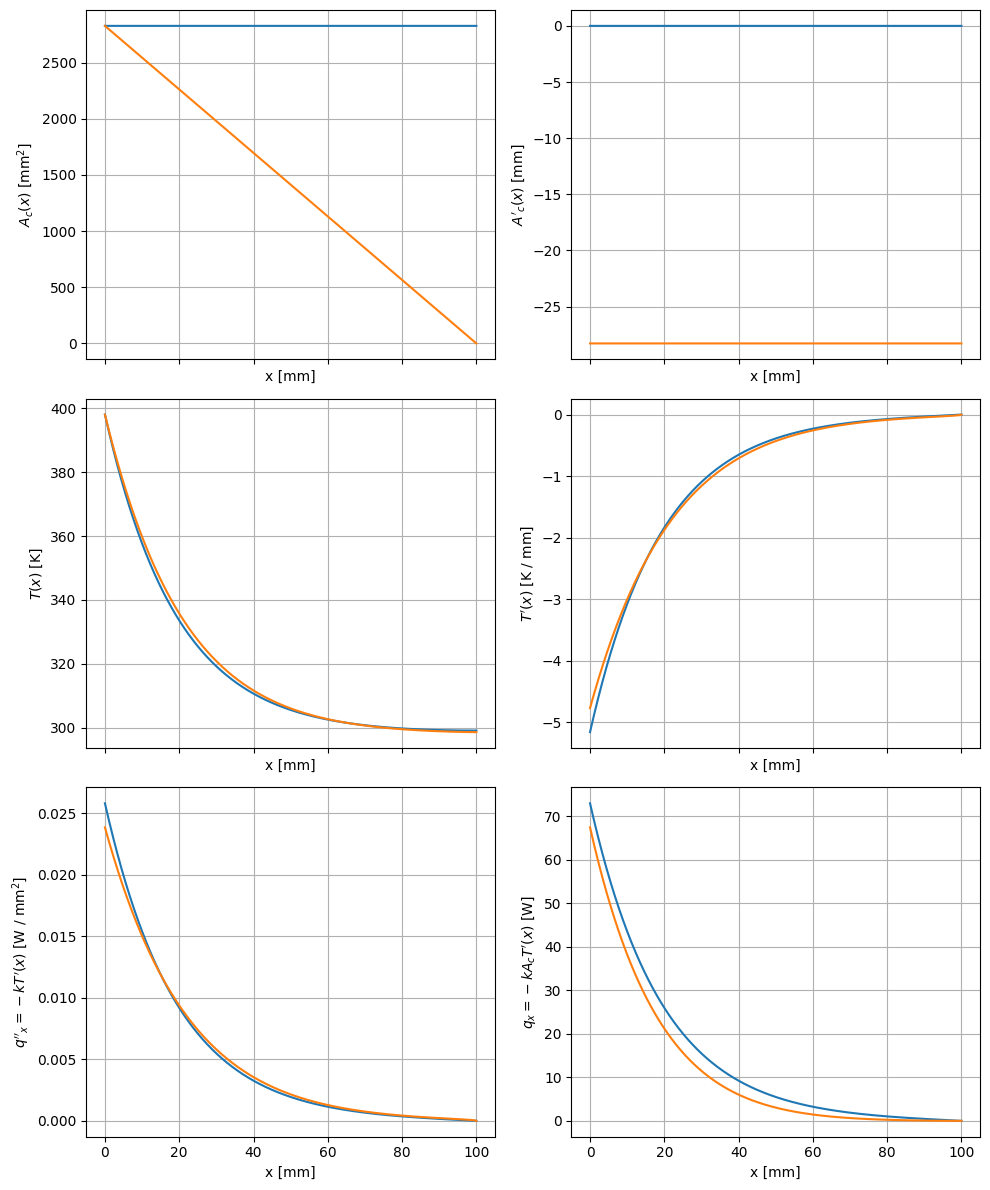

In [ ]:
fig, _ = plt.subplots(num=1, figsize=(10, 12), nrows=3, ncols=2, sharex="all")
x_plot = np.linspace(0, L, 100001)
plot_results(fig, result_uniform, x_plot, "constant cross-section")
plot_results(fig, result_linear, x_plot, "linear profile")

for ax in fig.axes:
    ax.set_xlabel(r"x [mm]")
    ax.grid(True)
plt.tight_layout()